# 手把手教你用Python实现人脸情绪识别，并在小程序中查询识别结果

##### 注：实现本文Python代码需要的包：opencv、numpy、matplotlib、sklearn、os，Python版本为Python3.7

人脸情绪识别在日常生活中有着极其广泛的用途，例如智慧课堂应用场景中识别学生的面部表情从而给予老师关于课程的反馈、家用监控系统中识别儿童的异常情绪等等。

本文中的情绪识别技术基于JAFFE数据集实现，主要的应用目标则是通过家用监控设备采集到的录像，实现自闭症儿童异常负面情绪的监测。

## 一、 基于图像特征提取和传统机器学习算法的情绪识别

### 0.人脸位置的检测

在进行人脸情绪识别时，首要任务就是抓取到图片中的目标人脸区域，再对人脸进行特征提取。在特征提取前，我们采用opencv包中自带的人脸检测文件进行目标区域的检测。将opencv包安装路径的cascades文件夹置于项目目录下，即可调用其中现有的模型。（cascades文件夹也会在本文末尾的GitHub中给出）
下面的detect函数展示了如何调用人脸检测的xml文件。

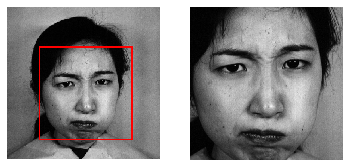

In [78]:
import cv2
import matplotlib.pyplot as plt
def detect(frame):
    face_casade = cv2.CascadeClassifier("cascades/haarcascade_frontalface_default.xml")  # 使用脸部检测
    while (True):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_casade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:  # 返回的x,y代表roi区域的左上角坐标，w,h代表宽度和高度
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            imagee = frame[y + 1:y + h-1, x + 2:x + w-1]
            roi_gray = gray[y + 1:y + h-1, x + 1:x + w-1]
        return imagee


img_init=cv2.imread('KA.AN2.40.tiff')
face=detect(img_init)
plt.subplot(1,2,1)
plt.imshow(img_init)
plt.axis('off') 
plt.subplot(1,2,2)
plt.imshow(face)
plt.axis('off') 
plt.show()

### 1.1 利用Gabor变换进行图像特征提取

数字图像处理中最常用的方法无疑是傅立叶变换，它将任意信号分解为许多不同频率正弦波的组合，可以实现信号在时域和频域的相互转换，但它最大的缺陷就是无法用于变化的非确定、非稳定信号。对于人脸图像这种非确定、非稳定信号，常用的一种特征提取方法是Gabor变换，它也被称为“窗口Fourier变换”。

Gabor变换的本质就是把信号划分成许多个小的间隔，再对每个小间隔进行傅立叶变换，从而兼顾信号在时域和频域的特性。对于二维情况下的图像，将小波变换与Gabor变换结合，得到的二维Gabor变换能够抓取图像中不同位置、不同频率、不同方向上的特征。换言之，二维Gabor变换在人脸图像中，可以较好地提取出人脸的眉毛、鼻子、嘴等面部关键区域的信息。

总而言之，Gabor滤波器是一种在图像处理领域极为优越的特征提取方法。

二维Gabor变换的表达式如下所示：

$g(x,y;\sigma,\theta,\lambda,\gamma,\varphi)=exp\{-\frac{x^2+\gamma^2y^2}{2\sigma^2}\}exp\{i(2\pi\frac{x}{\lambda}+\varphi)\}$

其中各个参数的意义如下：

$\lambda$是波长

$\theta$是角度

$\sigma$是高斯分布标准差

$\gamma$是椭圆率（横纵比），一般取0.5

$\varphi$是相位偏移

公式的后半部分用欧拉公式展开是一个正弦函数的形式，因此该公式实质上是一个高斯分布和一个正弦函数的乘积。
先从$x^2+\gamma^2 y^2$处入手看公式：

如果$\gamma=1$，那么Gabor滤波器的内核是一个圆形。

当椭圆率$\gamma$变动时，Gabor滤波器的内核随之变为不同的椭圆。

下文将利用opencv包实现基于Gabor滤波器的特征提取。

话不多说，直接上代码。首先调用需要的包：

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

一个Gabor滤波器的图像展示：

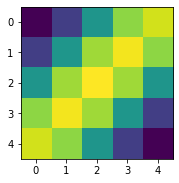

In [79]:
ksize=5
sigma=3  
theta=1*np.pi/4
lamda=1*np.pi/4
gamma=0.5
phi=0

kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
# x,y defines kernel size
# ktype:数据类型
plt.subplot(1,2,1)
plt.imshow(kernel)
plt.show()

下面依次尝试增加ksize和$\sigma$的值：
（注意，当$\sigma$过大时，可能会错过小图像中的一些特征）

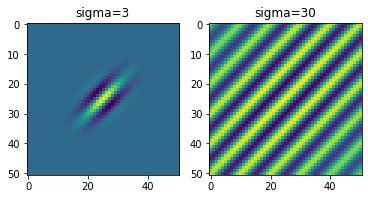

In [3]:
ksize=50
sigma=3  
theta=1*np.pi/4
lamda=1*np.pi/4
gamma=0.5
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
# x,y defines kernel size
# ktype:数据类型
plt.subplot(1,2,1)
plt.title('sigma=3')
plt.imshow(kernel)

ksize=50
sigma=30  # sigma过大时，会错过小图像中的一些特征。
theta=1*np.pi/4
lamda=1*np.pi/4
gamma=0.5
phi=0
plt.subplot(1,2,2)
plt.title('sigma=30')
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
plt.imshow(kernel)
plt.show()

改变滤波器角度$\theta$：

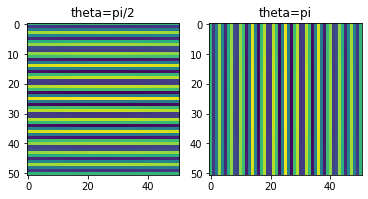

In [4]:
ksize=50
sigma=30
theta=1*np.pi/2
lamda=1*np.pi/4
gamma=0.5
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
# x,y defines kernel size
# ktype:数据类型
plt.subplot(1,2,1)
plt.title('theta=pi/2')
plt.imshow(kernel)
ksize=50
sigma=30  
theta=1*np.pi
lamda=1*np.pi/4
gamma=0.5
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
plt.subplot(1,2,2)
plt.title('theta=pi')
plt.imshow(kernel)
plt.show()

如果需要寻找图像垂直方向上的特征，则通过运用上图的垂直方向滤波器，可以阻止水平方向的所有特征。

改变波长的效果如下图：

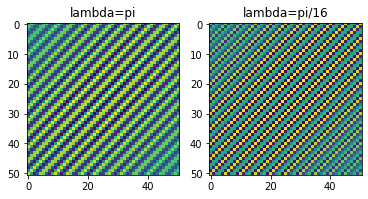

In [5]:
ksize=50
sigma=30
theta=1*np.pi/4
lamda=1*np.pi
gamma=0.5
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
# x,y defines kernel size
# ktype:数据类型
plt.subplot(1,2,1)
plt.title('lambda=pi')
plt.imshow(kernel)
ksize=50
sigma=30  
theta=1*np.pi/4
lamda=1*np.pi/16
gamma=0.5
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
plt.subplot(1,2,2)
plt.title('lambda=pi/16')
plt.imshow(kernel)
plt.show()

观察椭圆率$\gamma$对Gabor核的影响：($\gamma$分别取0.3, 1, 3)，可以看出，$\gamma$取1时，Gabor核的形状近似于一个正圆。

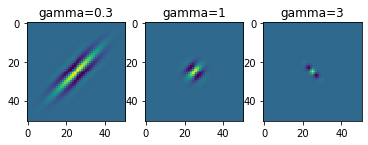

In [6]:
ksize=50
sigma=3
theta=1*np.pi/4
lamda=1*np.pi/4
gamma=0.3
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
# x,y defines kernel size
# ktype:数据类型
plt.subplot(1,3,1)
plt.title('gamma=0.3')
plt.imshow(kernel)
ksize=50
sigma=3
theta=1*np.pi/4
lamda=1*np.pi/4
gamma=1
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
plt.subplot(1,3,2)
plt.title('gamma=1')
plt.imshow(kernel)
ksize=50
sigma=3
theta=1*np.pi/4
lamda=1*np.pi/4
gamma=3
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
plt.subplot(1,3,3)
plt.title('gamma=3')
plt.imshow(kernel)
plt.show()

在人脸情绪识别的分类任务中，我们采用ksize=5的Gabor滤波器内核，在一张图片中的识别效果如下：

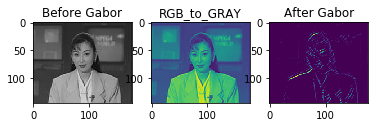

In [7]:
ksize=5
sigma=3
theta=1*np.pi/3.3
lamda=np.pi
gamma=0.5
phi=0
kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
img=cv2.imread('3-22.jpg')
img1=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  #RGB转灰度图像
plt.subplot(1,3,1)
plt.title('Before Gabor')
plt.imshow(img)
plt.subplot(1,3,2)
plt.title('RGB_to_GRAY')
plt.imshow(img1)
fimg=cv2.filter2D(img1,cv2.CV_8UC3, kernel)
plt.subplot(1,3,3)
plt.title('After Gabor')
plt.imshow(fimg)
plt.show()

以下是本项目中采用的$4\times 8$Gabor滤波器组：（四种窗口大小，八个方向）

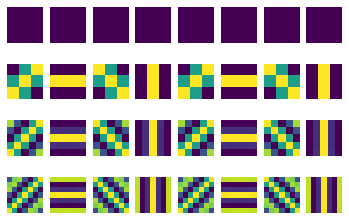

In [8]:
sigma=2*np.pi
lamda=np.pi
gamma=0.5
phi=0
j=0
for ksize in [1,3,5,7]:
    for theta in [1*np.pi/4, 2*np.pi/4, 3*np.pi/4, 4*np.pi/4, 5*np.pi/4, 6*np.pi/4, 7*np.pi/4, 8*np.pi/4]:
        j+=1
        kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
        plt.subplot(4,8,j)
        plt.axis('off') #去掉坐标轴
        plt.imshow(kernel)
plt.show()

上面图片与$4\times 8=32$个滤波器做卷积，得到的滤波效果如下图所示：

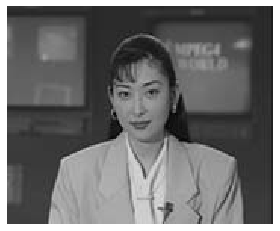

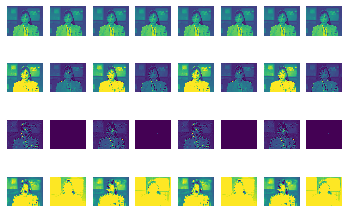

特征向量长度： 320000


In [9]:
img=cv2.imread('3-22.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()
img1=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  #RGB转灰度图像
sigma=2*np.pi
lamda=np.pi
gamma=0.5
phi=0
j=0
feature=[]
for ksize in [1,3,5,7]:
    for theta in [1*np.pi/4, 2*np.pi/4, 3*np.pi/4, 4*np.pi/4, 5*np.pi/4, 6*np.pi/4, 7*np.pi/4, 8*np.pi/4]:
        j+=1
        kernel=cv2.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
        fimg=cv2.filter2D(img1,cv2.CV_8UC3, kernel)
        plt.subplot(4,8,j)
        plt.axis('off') #去掉坐标轴
        plt.imshow(fimg)
        fimg=cv2.resize(fimg,(100,100))
        for i in range(100):
            for k in range(100):
                feature.append(fimg[i,k])
plt.show()
print('特征向量长度：',len(feature))

经过Gabor滤波器，原图片生成了32张子图。将每张子图的大小变为100\*100像素，再将每个像素点的像素值作为该子图的特征，从原图片中共得到$32\times 100\times 100=320000$个特征。

上述流程中提取的Gabor特征具有很好的识别性能，但它是非正交的，因此图像经过Gabor特征提取后，如果将每个像素点都作为特征，会导致特征维度较高和特征冗余。为此，采取下采样和PCA对上述特征向量进行降维。在下采样中，将图片的每个两两不相邻2\*2区域像素值的最大值作为该区域的特征，可以将图像维度变为80000.

下面的代码是基于JAFFE数据集的完整的Gabor特征提取代码：
（为实现人脸位置的捕捉，在代码所在目录调用了opencv安装路径中的cascade文件夹）

In [10]:
import numpy as np
import os
from sklearn.decomposition import PCA
import cv2
import matplotlib.pyplot as plt

def getSpecificFile(inputPath, key):
    face = []
    for file in os.listdir(inputPath):
        if os.path.splitext(file)[1] == '.tiff' or os.path.splitext(file)[1] == '.bmp' or os.path.splitext(file)[
            1] == '.png':  # 查找三种类型的图片文件
            if file.find(key) != -1:  # 满足条件往下进行
                sourcefile = os.path.join(inputPath, file)  # 拼路径
                face.append(sourcefile)
    return face


def detect(frame):
    face_casade = cv2.CascadeClassifier("cascades/haarcascade_frontalface_default.xml")  # 使用脸部检测
    # eye_casade = cv2.CascadeClassifier("cascades/haarcascade_eye.xml")
    # camera = cv2.VideoCapture(0)  # 0代表调用默认摄像头，1代表调用外接摄像头
    while (True):
        # ret, frame = camera.read()
        # print(ret)
        # print(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_casade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:  # 返回的x,y代表roi区域的左上角坐标，w,h代表宽度和高度
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 1)
            imagee = frame[y + 1:y + h, x + 1:x + w]
            roi_gray = gray[y + 1:y + h, x + 1:x + w]
            # eyes = eye_casade.detectMultiScale(roi_gray, 1.03, 5, 0, (40, 40))\
            # for (ex, ey, ew, eh) in eyes:
            #    cv2.rectangle(img, (x + ex, y + ey), (x + ex + ew, y + ey + eh), (0, 255, 0), 2)
        return imagee


# 构建Gabor滤波器
def build_filters():
    filters = []
    ksize = [0,1,2,3,4,5,6,7]  # gabor尺度
    lamda = np.pi  # 波长
    for theta in np.arange(0, np.pi, np.pi / 3):  # gabor方向，0°，45°，90°，135°，共四个
        for K in range(len(ksize)):
            kern = cv2.getGaborKernel((ksize[K], ksize[K]), 1.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5 * kern.sum()
            filters.append(kern)
    return filters


# Gabor特征提取
def getGabor(img, filters):
    res = []  # 滤波结果
    for i in range(len(filters)):
        # res1 = process(img, filters[i])
        accum = np.zeros_like(img)
        for kern in filters[i]:
            fimg = cv2.filter2D(img, cv2.CV_8UC1, kern)
            accum = np.maximum(accum, fimg, accum)
        res.append(np.asarray(accum))
    return res


if __name__ == "__main__":
    # 分类读取文件路径
    inputFilePath = "./jaffe"
    keys = ['FE', 'HA', 'NE', 'SA', 'SU', 'AN', 'DI']
    all_face = []
    for key in keys:
        all_face.append(getSpecificFile(inputFilePath, key))
    # HOG特征提取参数
    cell_size = 10
    bin_size = 9
    angle_unit = 360 / bin_size
    # 统一变为100*100
    GData=[]
    for label in range(len(all_face)):
        for facefile in all_face[label]:
            frame = cv2.imread(facefile)
            img1 = detect(frame)
            # 先用Gabor提取为24张子图，再对每张子图HOG
            filters = build_filters()
            a = getGabor(img1, filters)
            vector_Gabor = []
            for im in a:
                im=cv2.resize(im,(100,100))
                im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                for i in range(0,len(im),2):
                    for j in range(0,len(im[0]),2):
                        im_max=max(im[i,j],im[i+1,j],im[i,j+1],im[i+1,j+1])
                        vector_Gabor.append(im_max)
            vector_Gabor.append(label)
            GData.append(vector_Gabor)
    print(len(GData[0]))
    DataX=[]
    for i1 in range(len(GData)):
        dx=[]
        for i2 in range(len(GData[0])-1):
            dx.append(GData[i1][i2])
        DataX.append(dx)
    print(len(DataX[0]))
    X = np.array(DataX)
    pca = PCA(n_components=100)
    newX = pca.fit_transform(X)
    print('前100个主成分的影响强度：', pca.explained_variance_ratio_)          

60001
60000
前100个主成分的影响强度： [0.24469138 0.16571691 0.06864277 0.05752946 0.04413587 0.03732826
 0.02975447 0.02621188 0.02164525 0.01929114 0.01815591 0.01458595
 0.01218514 0.01124945 0.0101637  0.00904408 0.00859427 0.00794166
 0.00729023 0.00640118 0.00585138 0.00571549 0.00543365 0.00509097
 0.00469834 0.00446042 0.00418204 0.00409451 0.00378504 0.00365176
 0.00350408 0.00336936 0.00328531 0.00304458 0.0029199  0.00278465
 0.00274301 0.00271052 0.00251263 0.00247243 0.00234793 0.0023272
 0.00227736 0.00213253 0.0020435  0.0020063  0.00195433 0.00190055
 0.00186448 0.00174412 0.00172882 0.00167772 0.00162967 0.00156095
 0.00151341 0.00149772 0.00146794 0.00145424 0.00140676 0.00136507
 0.00131586 0.00128319 0.00127595 0.00122229 0.0012059  0.00117549
 0.00116187 0.00113411 0.00112947 0.00107858 0.0010395  0.001021
 0.00100786 0.00097517 0.00096784 0.0009569  0.00094894 0.0009256
 0.00088345 0.00085911 0.00085699 0.00084339 0.00083115 0.00081135
 0.00077827 0.00076443 0.00074658 0.000

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fullX=[]
for i in range(len(newX)):
    fx=newX[i].tolist()
    fx.append(GData[i][-1])
    fullX.append(fx)
dataset=fullX
np.random.seed(2015)
np.random.shuffle(dataset)
X_train, Y_train = list(), list()
X_test, Y_test = list(), list()
# test/train划分比例
k = 0.7
for i in range(int(len(dataset) * k)):
    X_train.append(dataset[i][0:len(dataset[0]) - 1])
    Y_train.append(dataset[i][-1])
for i in range(int(len(dataset) * k), len(dataset)):
    X_test.append(dataset[i][0:len(dataset[0]) - 1])
    Y_test.append(dataset[i][-1])
# SVM
svm = SVC(kernel='linear', max_iter=1000)
svm.fit(X_train, Y_train)
#joblib.dump(svm, 'SVC_L.pkl')
print("SVM Accuracy on training set is : {}".format(svm.score(X_train, Y_train)))
print("SVM Accuracy on test set is : {}".format(svm.score(X_test, Y_test)))
Y_pred = svm.predict(X_test)
print('各个分类准确率概览：\n',classification_report(Y_test, Y_pred))
print('混淆矩阵：\n',confusion_matrix(Y_test, Y_pred))

# ['FE', 'HA', 'NE', 'SA', 'SU', 'AN', 'DI']

SVM Accuracy on training set is : 1.0
SVM Accuracy on test set is : 0.8507462686567164
各个分类准确率概览：
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.78      1.00      0.88         7
           2       1.00      0.58      0.74        12
           3       0.82      0.90      0.86        10
           4       0.89      0.80      0.84        10
           5       0.91      0.91      0.91        11
           6       0.86      1.00      0.92         6

    accuracy                           0.85        67
   macro avg       0.86      0.87      0.85        67
weighted avg       0.87      0.85      0.85        67

混淆矩阵：
 [[10  0  0  0  0  0  1]
 [ 0  7  0  0  0  0  0]
 [ 1  1  7  1  1  1  0]
 [ 1  0  0  9  0  0  0]
 [ 1  1  0  0  8  0  0]
 [ 0  0  0  1  0 10  0]
 [ 0  0  0  0  0  0  6]]


<class 'numpy.ndarray'>


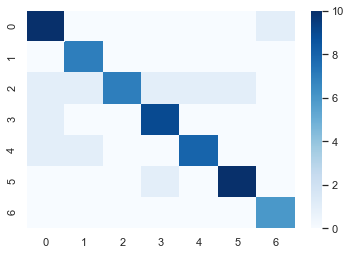

In [84]:
M=confusion_matrix(Y_test, Y_pred)
print(type(M))
import seaborn as sns
# 初始化参数
sns.set()
heatmap = sns.heatmap(M,cmap='Blues')
plt.show()

### 1.2 利用Gabor变换+HOG进行图像特征提取

在上述Gabor特征提取的过程中，我们直接以生成的子图中每个点的像素值作为整幅图像的特征值。为了进一步优化情绪识别的效果，考虑对每一个子图再做其他常见的图像特征提取。

HOG，又称作方向梯度直方图，相比其他常见的图像特征特征而言，HOG特征对图像几何和光学的形变都能保持很好的不变性，且它没有旋转和尺度不变性，因此计算量较小。

#### HOG特征提取主要分为以下几步：

###### （1）图像预处理

图像预处理分为图像灰度化和Gamma校正两步。

对于一个三维图像，HOG特征提取的过程中颜色信息的作用通常较小，因此将图像先转化为灰度图。

Gamma校正对输入图像进行颜色空间的标准化，将像素值转化为0-1之间的实数，从而调节图像的对比度，降低图像局部的阴影和光度变化对实验的影响，也可抑制噪声的干扰。

Gamma校正的公式（一般取$\gamma=0.5$）：$I(x,y)=I(x,y)^{\gamma}$

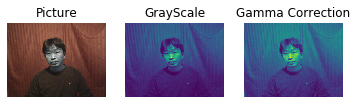

In [19]:
img=cv2.imread('000_0.bmp')
img_gray=cv2.imread('000_0.bmp',cv2.IMREAD_GRAYSCALE)
plt.subplot(1,3,1)
plt.axis('off') 
plt.title('Picture')
plt.imshow(img)
plt.subplot(1,3,2)
plt.axis('off') 
plt.title('GrayScale')
plt.imshow(img_gray)
plt.subplot(1,3,3)
plt.axis('off') 
plt.title('Gamma Correction')
imgG = np.sqrt(img_gray / float(np.max(img_gray)))
plt.imshow(imgG)
plt.show()

###### （2）计算每一个像素点的梯度值和方向

将图像中每一个像素点为中心的3\*3像素方格与Sobel算子做卷积运算，得到某点(x,y)处梯度值和方向的计算公式如下：

$
\left\{  
\begin{array}{**rcl**}
    G_x(x,y)=H(x+1,y)-H(x-1,y) & \\
    G_y(x,y)=H(x,y+1)-H(x,y-1) &\\
    G(x,y)=\sqrt{(G_x(x,y)^2+G_y(x,y)^2)} &\\
    \theta(x,y)=arctan\frac{G_y(x,y)}{G_x(x,y)} &   
\end{array}
\right.
$

其中$H(x,y)$表示像素点$(x,y)$处的像素值，$G_x(x,y)$和$G_y(x,y)$表示(x,y)处的水平、垂直梯度，$\theta(x,y)$表示点$(x,y)$处梯度的方向与x轴的夹角。

利用opencv可以写出上面几个公式：

In [29]:
height, width = imgG.shape
gradient_values_x = cv2.Sobel(imgG, cv2.CV_64F, 1, 0, ksize=5)
gradient_values_y = cv2.Sobel(imgG, cv2.CV_64F, 0, 1, ksize=5)
gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
gradient_magnitude = abs(gradient_magnitude)
print('图片中每个像素点处的梯度夹角：\n',gradient_angle)

图片中每个像素点处的梯度夹角：
 [[180.         180.         180.         ... 180.         180.
  180.        ]
 [270.         253.46669828 210.2467671  ... 203.64837159 201.79229488
  270.        ]
 [270.         254.48882547 226.47452867 ... 193.20797265 207.09995236
  270.        ]
 ...
 [270.         189.00153    192.12820732 ... 206.32532656 210.80116302
  270.        ]
 [ 90.         179.16216278 185.68675998 ... 201.7627233  196.57257904
   90.        ]
 [180.         180.         180.         ... 180.         180.
    0.        ]]


###### （3）每个cell的HOG特征的生成

将图像划分成许多cells(细胞单元)，每10×10=100个像素作为一个cell，且相邻的cell之间没有重合部分。在每个cell中，将所有梯度方向放入划分的9个部分（如图，这9个部分由0-360度均分得到），作为直方图的横轴，且对于每个部分内的所有像素点，把它们的梯度值累加作为直方图的纵轴。这样生成的直方图对应着一个9维向量。

In [30]:
# HOG特征提取子函数--cell的梯度
cell_size = 10
bin_size = 9
angle_unit = 360 / bin_size


def cell_gradient(cell_magnitude, cell_angle):
    orientation_centers = [0] * bin_size
    for k in range(cell_magnitude.shape[0]):
        for l in range(cell_magnitude.shape[1]):
            gradient_strength = cell_magnitude[k][l]
            gradient_angle = cell_angle[k][l]
            min_angle = int(gradient_angle / angle_unit) % 8
            max_angle = (min_angle + 1) % bin_size
            mod = gradient_angle % angle_unit
            orientation_centers[min_angle] += (gradient_strength * (1 - (mod / angle_unit)))
            orientation_centers[max_angle] += (gradient_strength * (mod / angle_unit))
    return orientation_centers

###### （4）每2×2个cell合成大的可重叠的block

HOG特征提取前图像的大小归一化时，为了使图像能够被完全划分为10×10的cell（也就是划分后没有多余像素），预先将Gabor滤波后得到的子图归一化为100×100像素大小，从而这些图像可以被划分为10×10个10×10的cell。将左上角2×2方格的cell构成一个block，再将block每次向右、向下平移1个cell的步长，直到覆盖整张图像，如此生成了9×9个block。注意到相邻的block之间是有重叠的，这样通过更全面地分析各个相邻像素之间的共同特征，提高了算法的准确率。

In [33]:
hog_vector = []
for i in range(cell_gradient_vector.shape[0] - 1):
    for j in range(cell_gradient_vector.shape[1] - 1):
        block_vector = []
        block_vector.extend(cell_gradient_vector[i][j])
        block_vector.extend(cell_gradient_vector[i][j + 1])
        block_vector.extend(cell_gradient_vector[i + 1][j])
        block_vector.extend(cell_gradient_vector[i + 1][j + 1])
        mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
        magnitude = mag(block_vector)
        if magnitude != 0:
            normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
            block_vector = normalize(block_vector, magnitude)
        hog_vector.append(block_vector)
# print('kkk:',np.array(hog_vector).shape)
features = sum(hog_vector, [])

###### （5）生成特征向量

将一个block内所有的cell的特征向量合并为一个新的向量，再将每个block对应的特征向量归一化，得到该block的HOG特征。最后将每张图片中所有的block的特征向量合并为一个新的向量，得到图片的HOG特征向量。在本文中，特征向量的维度为$6×4×4×9=864$。其中$6×4$为block数量，4为每个block中cell的数量，9为每个cell的特征向量的维度，也就是将360度均分成的部分数。

每张训练集、测试集图片经过上述HOG特征提取的过程，都可以生成一个864维的特征向量用于训练和预测。上述HOG特征提取过程完整的代码如下：

In [34]:

cell_size = 10  #每个cell的尺寸
bin_size = 9  #将0--360度分为的部分数
angle_unit = 360 / bin_size  #每个部分占有的角度大小
def cell_gradient(cell_magnitude, cell_angle):
    orientation_centers = [0] * bin_size
    for k in range(cell_magnitude.shape[0]):
        for l in range(cell_magnitude.shape[1]):
            gradient_strength = cell_magnitude[k][l]
            gradient_angle = cell_angle[k][l]
            min_angle = int(gradient_angle / angle_unit) % 8
            max_angle = (min_angle + 1) % bin_size
            mod = gradient_angle % angle_unit
            orientation_centers[min_angle] += (gradient_strength * (1 - (mod / angle_unit)))
            orientation_centers[max_angle] += (gradient_strength * (mod / angle_unit))
    return orientation_centers


def HOG_extract(img):
    img = np.sqrt(img / float(np.max(img)))
    # cv2.imshow('Image', img)
    # cv2.imwrite("Image-test2.jpg", img)
    # cv2.waitKey(0)
    height, width = img.shape
    gradient_values_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    gradient_values_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
    gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
    gradient_magnitude = abs(gradient_magnitude)
    cell_gradient_vector = np.zeros((round(height / cell_size), round(width / cell_size), bin_size))
    # print(cell_gradient_vector.shape)
    for i in range(cell_gradient_vector.shape[0]):
        for j in range(cell_gradient_vector.shape[1]):
            cell_magnitude = gradient_magnitude[i * cell_size:(i + 1) * cell_size,
                             j * cell_size:(j + 1) * cell_size]
            cell_angle = gradient_angle[i * cell_size:(i + 1) * cell_size,
                         j * cell_size:(j + 1) * cell_size]
            cell_gradient_vector[i][j] = cell_gradient(cell_magnitude, cell_angle)
    hog_vector = []
    for i in range(cell_gradient_vector.shape[0] - 1):
        for j in range(cell_gradient_vector.shape[1] - 1):
            block_vector = []
            block_vector.extend(cell_gradient_vector[i][j])
            block_vector.extend(cell_gradient_vector[i][j + 1])
            block_vector.extend(cell_gradient_vector[i + 1][j])
            block_vector.extend(cell_gradient_vector[i + 1][j + 1])
            mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
            magnitude = mag(block_vector)
            if magnitude != 0:
                normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                block_vector = normalize(block_vector, magnitude)
            hog_vector.append(block_vector)
    features = sum(hog_vector, [])
    features.append(1)
    return features

将上述代码用于Gabor特征提取产生的每一张子图，即可生成原图片的Gabor+HOG特征向量。

### 1.3 人脸T型区域的特征提取

对于人脸的面部特征提取，另外一种方法是T型区域特征提取。T型区域，顾名思义，就是对人脸的眼部、眉毛、鼻子、嘴这几项特征较为显著的区域合并后产生的一个形状类似大写字母'T'的区域。在T型区域内的人脸部分更能反应整张人脸的特征，也能够降低数据的维度。但这种方法的缺陷也较为明显，它在应用场景中只能用于正脸的情形。

下面的代码将人脸的T型区域取出，并做HOG特征提取：

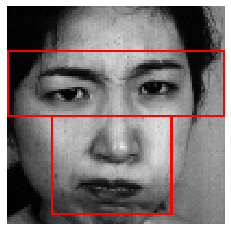

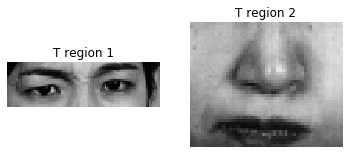

In [80]:
def detect(frame):
    face_casade = cv2.CascadeClassifier("cascades/haarcascade_frontalface_default.xml")  # 使用脸部检测
    while (True):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_casade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:  # 返回的x,y代表roi区域的左上角坐标，w,h代表宽度和高度
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 1)
            imagee = frame[y + 1:y + h, x + 1:x + w]
            roi_gray = gray[y + 1:y + h, x + 1:x + w]
        return imagee
    
    
def getTfeature(img):
    immm = detect(img)
    immm = cv2.resize(immm, (100, 100))
    img1 = immm[20:50, ]
    img2 = immm[50:95, 20:75]
    img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    vGH1 = HOG_extract(img1g)
    vGH2 = HOG_extract(img2g)
    vector_A = [vGH1, vGH2]
    vector_A = sum(vector_A, [])
    return (img1,img2,vector_A)  # 如果需要特征向量，取返回值中的vectorA即可。


img_i=cv2.imread('KA.AN2.40.tiff')
img=detect(img_i)
imgg=cv2.resize(img,(100,100))
cv2.rectangle(imgg, (0, 20), (99, 50), (255, 0, 0), 1)
cv2.rectangle(imgg, (20, 50), (75, 95), (255, 0, 0), 1)
plt.imshow(imgg)
plt.axis('off') #去掉坐标轴
plt.show()
img1=getTfeature(img)[0]
img2=getTfeature(img)[1]
plt.subplot(1,2,1)
plt.title('T region 1')
plt.axis('off') 
plt.imshow(img1)
plt.subplot(1,2,2)
plt.title('T region 2')
plt.axis('off') 
plt.imshow(img2)
plt.show()

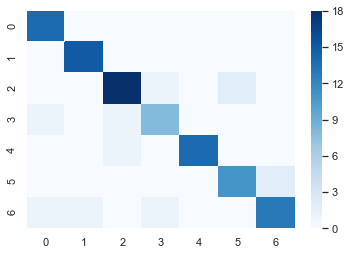

In [89]:
M=[[14 ,0  ,0 , 0 , 0 , 0,  0],
 [ 0 ,15 , 0,  0  ,0,  0  ,0],
 [ 0  ,0 ,18 , 1  ,0 , 2  ,0],
 [ 1  ,0  ,1  ,8  ,0  ,0  ,0],
 [ 0 , 0 , 1 , 0 ,14  ,0 , 0],
 [ 0 , 0 , 0,  0,  0 ,11,  2],
 [ 1 , 1,  0 , 1 , 0  ,0 ,13]]
sns.set()
heatmap = sns.heatmap(M,cmap='Blues')
plt.show()